# Motion Corrections in BART

This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to perform motion corrected reconstructions with BART.


## Outline
1. Bart Setup
2. Conventions in BART
3. Rigid body motion correction
4. Non-rigid motion fields for PICS


**Author**: [Moritz Blumenthal](mailto:blumenthal@@tugraz.at)

**Presenter**: [Moritz Blumenthal](mailto:blumenthal@@tugraz.at)

**Institution**: Institute of Biomedical Imaging, Graz University of Technology, Austria



## 1 Setup BART

This notebook is designed to run on a local system and on Google Colab. It uses the python kernel, however, almost all commands use the `%%bash` cell magic to be executed in a `bash` subshell.

### 1.1 Google Colab

To run BART on Google Colab, this notebook automatically installs dependencies and sets up the GPUs if the environment variable `COLAB=1`is set. If you run this notebook on your local system, you might not want this setup. Please set `COLAB=0` in this case. For a detailed explanation, see the [How to Run BART on Google Colaboratory](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

In [1]:
%env COLAB=1

env: COLAB=0


Not all GPUs on Google Colab support CUDA 11, we downgrade CUDA if necessary:

In [2]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Use CUDA 10.1 when on Tesla K80
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

if [ "Tesla K80" = "$GPU_NAME" ]; then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."
    cd /usr/local; rm cuda; ln -s cuda-10.1 cuda
fi


Skipp cell (not on Colab)


### 1.2 Install libraries

We install dependencies for BART. Make sure that you have installed the requirements if you run locally:

In [3]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev time &> /dev/null

Skipp cell (not on Colab)


### 1.3 Clone and Compile BART

We clone BART into the current working directory of this notebook and delete any previous installation in this directory.

In [4]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Clone Bart
[ -d bart ] && rm -r bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart

# Define compile options
COMPILE_SPECS=" PARALLEL=1
                PARALLEL_NJOBS=16
                CUDA=1
                "

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local


if [ $COLAB -eq "1" ]
then
    # set path to cuda for Colab
    echo "CUDA_BASE=/usr/local/cuda" >> Makefiles/Makefile.local
    echo "CUDA_LIB=lib64" >> Makefiles/Makefile.local
fi

make &> /dev/null

Skipp cell (not on Colab)


### 1.4 Add BART to PATH variable

We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [5]:
import os
import sys

if os.environ["COLAB"] == "1":
	os.environ['BART_TOOLBOX_PATH']=os.getcwd()+"/bart/"

os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")

# Environment telling BART to use GPU if available
os.environ['BART_GPU']="1"
os.environ['BART_GPU_GLOBAL_MEMORY']="1"
os.environ['BART_DEBUG_LEVEL']="4"

Check BART setup:

In [6]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/home/mblum/Bart/bart//bart
# BART version: 
v0.9.00-536-g84ea7b1


In [7]:
%matplotlib inline

import cfl
import numpy as np
from matplotlib import pyplot as plt

def plot(files, names=None, title=None, shape=None, figsize=16, window=1., savepath=None):
	import numpy as np
	from matplotlib import pyplot as plt
	import cfl

	if shape is None:
		shape = (1, len(files))

	fig, axs = plt.subplots(shape[0], shape[1], squeeze=False, constrained_layout=True, figsize=(figsize, figsize * shape[0] / shape[1]))

	axs = axs.flatten()

	max = 0.

	for i, f in enumerate(files):
		dat = np.abs(cfl.readcfl(f)).squeeze()
		max = max if max > np.max(dat) else np.max(dat)
		
	for i, f in enumerate(files):
		dat = np.abs(cfl.readcfl(f)).squeeze()
		axs[i].imshow(dat,cmap = "gray", vmax=max * window)
		axs[i].set_title(f if title is None else title[i])
		axs[i].axis('off')

	if savepath is not None:
		plt.savefig(savepath)

	plt.show()


## 2 BART Conventions

### Definition of the nuDFT

$$
\begin{aligned}
\hat{f}(c_m)=\hat{f}_m 
&= \frac{1}{\sqrt{N}}\sum_{|c_n| \le \frac{N}{2}}\exp\left(\frac{-2\pi i}{N}\left(n-\frac{N}{2}\right)c_m\right)f_n
\end{aligned}
$$

* $f_n$ values on the Cartesian grid (with center N/2)
* $c_m$ coordinates of the non-Cartesian sample points (trajectory)
* $\hat{f}_m$ k-Space data at k-Space coordinate $c_m$

For Cartesian trajectories, this definition is consistent with the centered unitary FFT. As the grid spacing of $f_n$ is measured in units $\frac{\text{FoV}}{N}$, the k-Space coordinates are measured in units $\frac{1}{\text{FoV}}$.

**Warning**: The definition varies for different toolboxes by scaling of the data and/or trajectory.

![title](conventions.png)

Grid to world transformation, i.e. transforming grid coordinates $(n_x, n_y, n_z)$ to world coordinates measured in units of FoV in the respective direction:
$$\begin{pmatrix}
\frac{1}{N_x} & 0 & 0 & -\frac{N_x//2}{N_x} \\
0 & \frac{1}{N_y} & 0 & -\frac{N_y//2}{N_y} \\
0 & 0 & \frac{1}{N_z} & -\frac{N_z//2}{N_z}
\end{pmatrix}
\begin{pmatrix}
n_x \\ n_y \\ n_z \\ 1
\end{pmatrix}
$$


### Basics of Image Registration
* $I_r(\vec{x}_r)$ - reference image
* $I_m(\vec{x}_m)$ - moved image
* $\Phi$ - coordinate transformation
* Registration: Find $\Phi$ such that $I_r(\vec{x}_r) = I_m(\vec{x}_m=\Phi(\vec{x}_r))$
* Rigid body motion: $\Phi(\vec{x}_r) = R\vec{x}_r + \vec{a}$
	* $R$ - rotation matrix around the origin
	* $\vec{a}$ - translation vector (units of FoV)
* Non-rigid motion: $\Phi(\vec{x}_r) = \vec{x}_r + \vec{u}(\vec{x}_r)$
	* $\vec{u}(\vec{x}_r)$ - displacement field units of grid points
	* vector components of $\vec{u}$ are stored in BART dimension 8

## 3 Rigid Body Motion Correction

$$I_r(\vec{x}_r) = I_m(R\vec{x}_r+\vec{a})\Rightarrow\mathcal{F}[I_r](R^T \vec{k}) = \exp(i2\pi \vec{a}\cdot \vec{k})\mathcal{F}[I_m](\vec{k})$$

1. Calibrationless reconstruction with NLINV
2. Rigid registration (affinereg)
3. Interpolation in image space
4. Correction in k-space

In [8]:
%%bash

wget -nc -O ksp_ref.hdr https://zenodo.org/record/13585332/files/ksp_ref.hdr
wget -nc -O ksp_ref.cfl https://zenodo.org/record/13585332/files/ksp_ref.cfl

wget -nc -O ksp_mov.hdr https://zenodo.org/record/13585332/files/ksp_mov.hdr
wget -nc -O ksp_mov.cfl https://zenodo.org/record/13585332/files/ksp_mov.cfl

bart show -m ksp_ref


File ‘ksp_ref.hdr’ already there; not retrieving.
File ‘ksp_ref.cfl’ already there; not retrieving.
File ‘ksp_mov.hdr’ already there; not retrieving.
File ‘ksp_mov.cfl’ already there; not retrieving.


Type: complex float
Dimensions: 16
AoD:	1	512	1597	16	1	1	1	1	1	1	1	1	1	1	1	1


### 3.1 Calibrationless Reconstruction

In [9]:
%%bash

bart traj -R180 -r -D -o2 -x256 -y1597 trj

bart nlinv -i12 -S -t trj ksp_ref img_ref col_ref
bart nlinv -i12 -S -t trj ksp_mov img_mov col_mov

bart saxpy -- -1 img_ref img_mov diff

Est. image size: 256 256 1
ksp : [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:     [256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:      [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg:    [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]

NUFFT: Toeplitz mode
ksp : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   1   1   1   1   1 

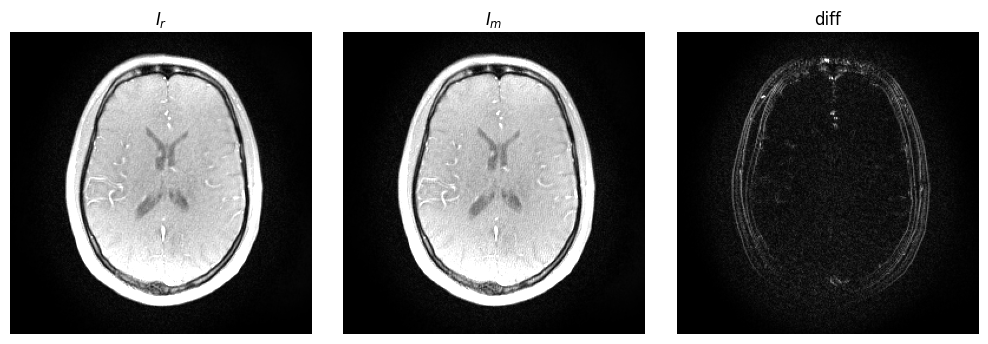

In [10]:
plot(["img_ref","img_mov", "diff"], title=("$I_r$", "$I_m$", "diff"), figsize=10, savepath="fig_brain.pdf", window=0.3)

### 3.2 Rigid Registration

In [11]:
%%bash

bart affinereg -R img_ref img_mov aff

L-BFGS iter 0: obj: -1.436505e+00!
L-BFGS iter 1: obj: -1.473318e+00!
L-BFGS terminated after 1 iterations as no new stepsize could be found (stp = 3.051758e-05)!
L-BFGS iter 0: obj: -1.270813e+00!
L-BFGS iter 1: obj: -1.271370e+00!
L-BFGS iter 2: obj: -1.272334e+00!
L-BFGS iter 3: obj: -1.284284e+00!
L-BFGS iter 4: obj: -1.285181e+00!
L-BFGS iter 5: obj: -1.285376e+00!
L-BFGS converged after 6 iterations with fopt=-1.285376e+00
L-BFGS iter 0: obj: -1.063795e+00!
L-BFGS converged after 1 iterations with fopt=-1.063801e+00
Affine Transform Matrix:
  +1.00e+00  -9.05e-03  +0.00e+00  -2.21e-04
  +9.05e-03  +1.00e+00  -0.00e+00  -2.14e-03
  +0.00e+00  +0.00e+00  +1.00e+00  +0.00e+00


### 3.3 Interpolation in Image Space

In [12]:
%%bash

IMG_FLAGS=$(bart bitmask 0 1 2)

bart interpolate -A $IMG_FLAGS img_mov aff img_mov_int
bart saxpy -- -1 img_ref img_mov_int diff_int


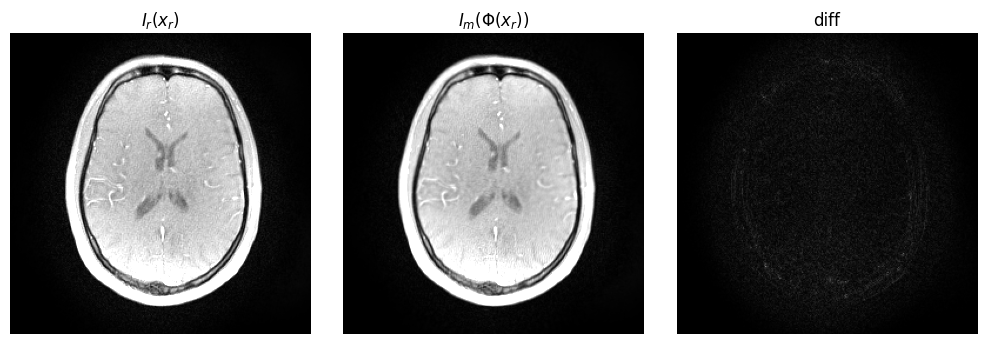

In [13]:
plot(["img_ref","img_mov_int", "diff_int"], title=(r"$I_r(x_r)$", r"$I_m(\Phi(x_r))$", "diff"), figsize=10, savepath="fig_brain_cor.pdf", window=0.3)

### 3.4 Correction in k-Space

In [14]:
%%bash

#This script uses bart fovshift shift and rotates the trajectory with bart fmac
$BART_TOOLBOX_PATH/scripts/affine_kspace.sh ksp_mov trj aff ksp_cor trj_cor

bart nlinv -i12 -S -t trj_cor ksp_cor img_mov_cor col_mov_cor
bart saxpy -- -1 img_ref img_mov_cor diff_cor


Est. image size: 256 256 1
ksp : [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:     [256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:      [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg:    [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]

NUFFT: Toeplitz mode
ksp : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   1   1   1   1   1 

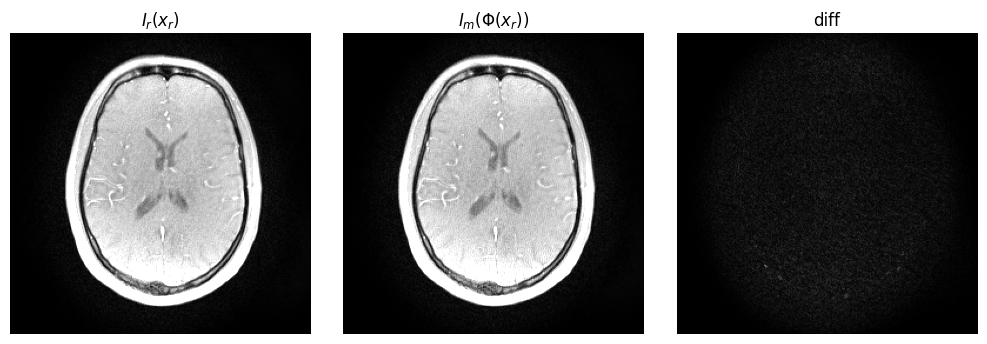

In [15]:
plot(["img_ref","img_mov_cor", "diff_cor"], title=(r"$I_r(x_r)$", r"$I_m(\Phi(x_r))$", "diff"), figsize=10, savepath="fig_brain_cor_ksp.pdf", window=0.3)

## 4 Non-rigid motion fields for PICS

0. Understand the data
1. Prepare data from RAGA measurement
2. Self-gating with SSA-FARY
3. Sensitivity estimation with NLINV (ncalib)
4. Motion-resolved GRASP reconstruction (pics)
5. Estimation of motion fields (estmotion)
6. Motion-compensated reconstruction (pics)



### 4.0 Understand the data

In [16]:
%%bash

wget -nc -O ksp_lung.hdr https://zenodo.org/record/13585332/files/ksp_lung.hdr
wget -nc -O ksp_lung.cfl https://zenodo.org/record/13585332/files/ksp_lung.cfl

bart show -m ksp_lung

File ‘ksp_lung.hdr’ already there; not retrieving.
File ‘ksp_lung.cfl’ already there; not retrieving.


Type: complex float
Dimensions: 16
AoD:	1	512	1597	24	1	1	1	1	1	1	10	1	1	1	1	1


In [17]:
%%bash

bart traj -R90 -x 512 -D -y 1597 _trj
bart repmat 10 10 _trj trj

In [18]:
%%bash

bart nufft -i -t trj ksp_lung cim

bart rss 8 cim rss
bart slice 10 0 rss img

Est. image size: 512x512x1
ksp : [  1 512 1597  24   1   1   1   1   1   1  10   1   1   1   1   1 ]
cim : [512 512   1  24   1   1   1   1   1   1  10   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1  10   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512 1597   1   1   1   1   1   1   1  10   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1  10   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1  10   1   1   1   1   1 ]
lsqr: add GPU wrapper
	 cg:  50
Done.


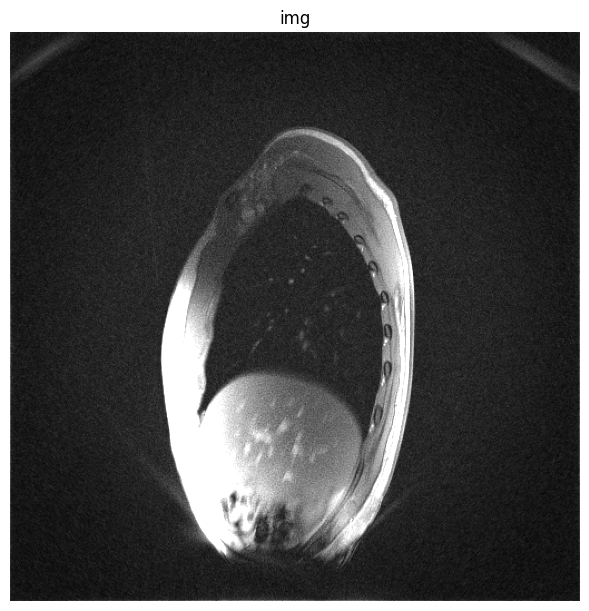

In [19]:
plot(["img"], figsize=6, window=0.2)

### 4.1 Prepare data from RAGA measurement

For more details, see the publication:

*Scholand, N., Schaten, P., Graf., C. et al.* (2024). **Rational Approximation of Golden Angles: Accelerated Reconstructions for Radial MRI**. MRM

In [20]:
%%bash

# Reorder linearly aranged data to temporal acquisition order

bart raga 1597 idx

bart bin -o idx trj _trj
bart reshape $(bart bitmask 2 10) 1 15970 _trj trj

bart bin -o idx ksp_lung _ksp
bart reshape $(bart bitmask 2 10) 1 15970 _ksp ksp

Golden Ratio Index is set to:	1
Reorder binning...


Reorder binning...


### 4.2 Self-gating with SSA-FARY

For more details, see the publication:

*Rosenzweig, S., Scholand, N., Holme, H. & Uecker, M.* (2020). **Rational Approximation of Golden Angles: Accelerated Reconstructions for Radial MRI**. MRM.

1. Obtain dc sample from symmetric trajectory

In [21]:
%%bash

bart fft -i 2 ksp _t1
bart fovshift -p -s0:-0.5:0 _t1 _t2
bart avg 7 _t2 dc1


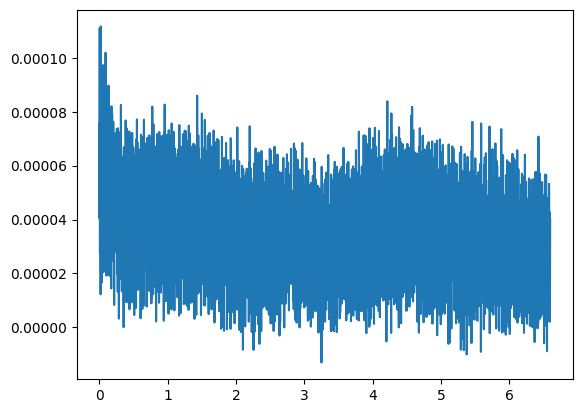

In [22]:
dc = cfl.readcfl("dc").squeeze().real
t = np.array(range(dc.shape[1]))*0.0033
plt.plot(t[:2000], dc[0,:2000])
plt.show()

2. Remove harmonics of angular frequency

In [23]:
%%bash

bart rmfreq trj dc dc_rm

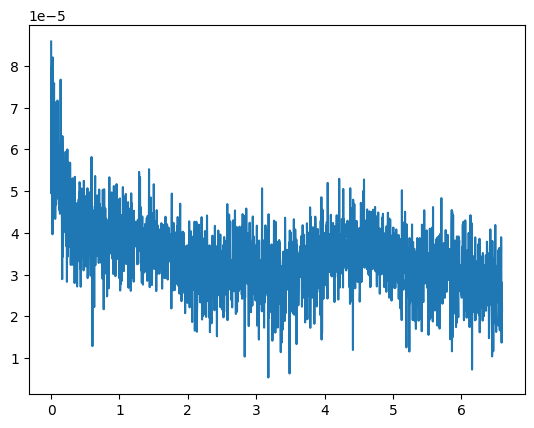

In [24]:
dc = cfl.readcfl("dc_rm").squeeze().real
t = np.array(range(dc.shape[1]))*0.0033
plt.plot(t[:2000], dc[0,:2000])
plt.show()

3. Average 10 consequtive spokes to speed up computation

In [25]:
%%bash

bart reshape $(bart bitmask 2 10) 10 1597 dc_rm _dc_rm
bart avg $(bart bitmask 2) _dc_rm dc_low

bart squeeze dc_low _dc
bart transpose 0 1 _dc dc_low

4. Make real and imaginary part independent channels

In [26]:
%%bash

bart creal dc_low dc_real
bart scale -- -1i dc_low dci
bart creal dci dc_imag
bart join 1 dc_real dc_imag self_nav

loading dc_real
loading dc_imag
done copying file 0
done copying file 1


5. SSA-FARY

In [27]:
%%bash

bart ssa -w 75 self_nav EOF
bart transpose 1 11 EOF _tmp
bart transpose 0 10 _tmp eof

Performing SSA-FARY


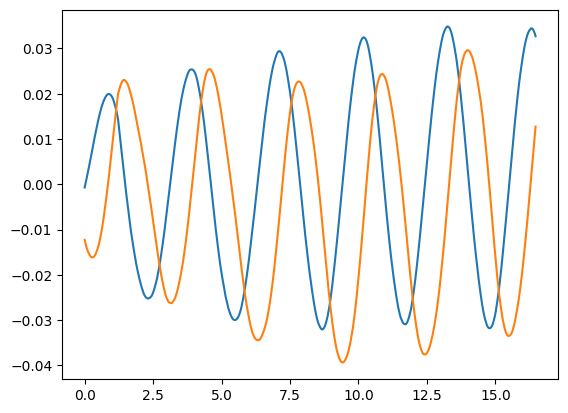

In [28]:
eof = cfl.readcfl("eof").squeeze().real
t = np.array(range(eof.shape[1]))*0.033
plt.plot(t[:500], eof[:500,0])
plt.plot(t[:500], eof[:500,1])
plt.show()

6. Binning

In [29]:
%%bash

bart reshape $(bart bitmask 1 2 10) 5120 1 1597 trj _trj
bart reshape $(bart bitmask 1 2 10) 5120 1 1597 ksp _ksp

bart bin -R15 -C1 -a350 eof _ksp _ksg
bart bin -R15 -C1 -a350 eof _trj _tsg
 
bart reshape $(bart bitmask 1 2) 512 $(bart show -d 2 _tsg)0 _tsg tsg
bart reshape $(bart bitmask 1 2) 512 $(bart show -d 2 _ksg)0 _ksg ksg

bart show -m ksg

Quadrature binning...
Quadrature binning...
Type: complex float
Dimensions: 16
AoD:	1	512	1130	24	1	1	1	1	1	1	1	15	1	1	1	1


### 4.3 Sensitivity estimation with NLINV (ncalib)

NLINV is a method to jointly estimate sensitivity maps and images from (potentially non-Cartesian) k-space data. ncalib is a wrapper for NLINV estimating the sensitivity maps low frequency k-space data.

In [30]:
%%bash

bart -l$(bart bitmask 10 11) -r ksg ncalib -x512:512:1 --cgiter=25 -i10 -t tsg ksg col

#normalize the coil sensitivity maps to pixel-wise unit norm
COIL_FLAG=$(bart bitmask 3)
bart normalize $COIL_FLAG col coln

ksp : [  1 512 1130  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 48  48   1  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512 1130  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:     [ 48  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:      [ 16  16   1  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
mask:       [  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg:    [ 48  48   1  24   1   1   1   1   1   1   1   1   1   1   1   1 ]

NUFFT: Toeplitz mode
ksp : [  1 512 1130   1   1   1   1   1  

### 4.4 Motion-resolved GRASP reconstruction (pics)

In [31]:
%%bash

IMG_FLAGS=$(bart bitmask 0 1)
TIME_FLAG=$(bart bitmask 11)

bart pics -S -i100 -RT:$IMG_FLAGS:0:0.00001 -RT:$TIME_FLAG:0:0.01 -t tsg ksg coln img_mres

GPU reconstruction
ksp : [  1 512 1130  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
cim : [512 512   1  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
cim : [1024 1024   1   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
Scaling: 0.020822! (max = 0.020822/p90 = 0.005535/median = 0.001149)
Inverse scaling of the data: 0.020822
TV regularization: 0.000010
TV regularization: 0.010000
Regularization terms: 2, Supporting variables: 0
ADMM
lsqr: add GPU wrapper
	 cg:  10
iter	cgiter	       rho	       tau	    r norm	   eps pri	    s norm	  eps dual	       obj	    relMSE
  0

In [32]:
%%bash

bart show -m img_mres

Type: complex float
Dimensions: 16
AoD:	512	512	1	1	1	1	1	1	1	1	1	15	1	1	1	1


### 4.5 Estimation of motion fields (estmotion)

In [33]:
%%bash

bart slice 11 0 img_mres img_ref

IMG_FLAGS=$(bart bitmask 0 1)

bart -l$(bart bitmask 11) -r img_mres estmotion -l4 $IMG_FLAGS img_ref img_mres mot imot

bart interpolate -D $IMG_FLAGS img_mres mot img_int

Generate Gaussian Pyramide:
	Level 0: sigma=0.000000, dims=[512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 1: sigma=2.000000, dims=[256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 2: sigma=4.000000, dims=[128 128   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 3: sigma=8.000000, dims=[ 64  64   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0
Generate Gaussian Pyramide:
	Level 0: sigma=0.000000, dims=[512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 1: sigma=2.000000, dims=[256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 2: sigma=4.000000, dims=[128 128   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 3: sigma=8.000000, dims=[ 64  64   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0
Generate

### 4.6 Motion-compensated reconstruction (pics)

In [34]:
%%bash

IMG_FLAGS=$(bart bitmask 0 1)
TIME_FLAG=$(bart bitmask 11)

bart pics -S -i100 -RT:$IMG_FLAGS:0:0.00001 --motion-field=imot -RT:$TIME_FLAG:0:0.01        -t tsg ksg coln img_imoco_TV
bart pics -S -i100 -RT:$IMG_FLAGS:0:0.00001 --motion-field=imot --shared-img-dims=$TIME_FLAG -t tsg ksg coln img_imoco


GPU reconstruction
ksp : [  1 512 1130  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
cim : [512 512   1  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
cim : [1024 1024   1   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1   1 ]
Scaling: 0.029377! (max = 0.029377/p90 = 0.005488/median = 0.001153)
Inverse scaling of the data: 0.029377
TV regularization: 0.000010
TV regularization: 0.010000
Regularization terms: 2, Supporting variables: 0
ADMM
lsqr: add GPU wrapper
	 cg:  10
iter	cgiter	       rho	       tau	    r norm	   eps pri	    s norm	  eps dual	       obj	    relMSE
  0

### 4.7 Visualization

In [35]:
%%bash

bart extract 0 128 384 1 128 384 11 0 1 img_mres img_mres_res
bart extract 0 128 384 1 128 384 11 0 1 img_int img_int_res
bart extract 0 128 384 1 128 384 11 0 1 img_imoco_TV img_imoco_TV_res
bart extract 0 128 384 1 128 384 11 0 1 img_imoco img_imoco_res


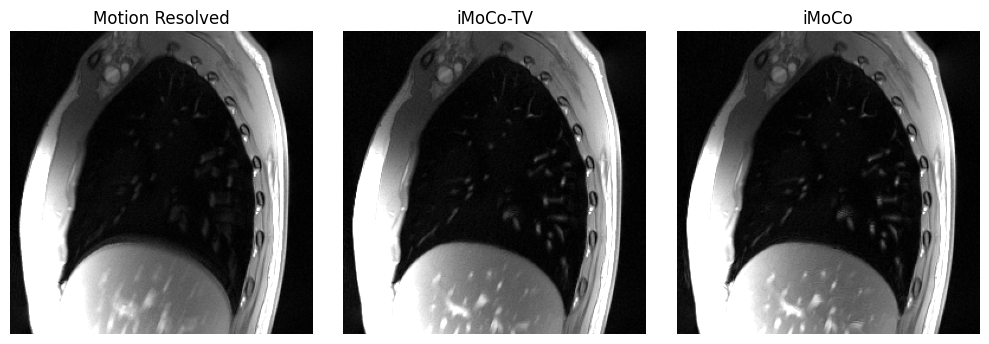

In [36]:
plot(["img_mres_res","img_imoco_TV_res","img_imoco_res"], title=["Motion Resolved", "iMoCo-TV", "iMoCo"], window=0.2, savepath="iMoCo.pdf", figsize=10)